In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'bis':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bas':   ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08',
              'bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

## Define max response option per scale (0-indexed).
scale_max = [3,3,3,3,3,3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(reject.subject)]

## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    surveys[k] = surveys[v].sum(axis=1)
    
## Merge infrequency items.
surveys = surveys.merge(reject[['platform','subject','infreq']])
surveys['infreq'] = np.where(surveys['infreq'], 1, 0)

## Restrict survey to valid items.
items = surveys[['platform','subject','infreq']+np.concatenate([*subscales.values()]).tolist()]

## Melt DataFrame.
scores = surveys[['platform','subject','infreq']+list(subscales.keys())]

## Section 2: Permutation Testing

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define items of interest.
cols = items.filter(regex='-q').columns

## Compute correlation matrices.
Omega_0 = items.query('infreq==0')[cols].corr(method='spearman')
Omega_1 = items.query('infreq==1')[cols].corr(method='spearman')

## Compute difference between correlation matrices.
delta = Omega_0 - Omega_1

## Compute SRMR. 
srmr_ix = np.tril_indices_from(delta, k=-1)
srmr = np.sqrt(np.square(delta.values[srmr_ix]).mean())

## Compute average iteritem correlations.
iic = np.zeros(( len(subscales), len(subscales) ))

ss = list(subscales.keys())
for i in range(len(subscales)):
    
    for j in range(i, len(subscales)):
        
        ## Extract correlation matrix.
        corr = delta.loc[subscales[ss[i]],subscales[ss[j]]].values
        
        ## Store correlations.
        if i==j: iic[j,i] = corr[np.tril_indices_from(corr, k=-1)].mean()
        else: iic[j,i] = corr.mean()
        

In [ ]:
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_srmr = np.zeros(n_iter)
null_iic = np.zeros((n_iter, *iic.shape))

## Main loop.
permuted = items.copy()
for n in tqdm(range(n_iter)):
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Compute difference of null correlation matrix.
    null = permuted.query('infreq==0')[cols].corr(method='spearman') -\
           permuted.query('infreq==1')[cols].corr(method='spearman')
    
    ## Compute null SRMR. 
    null_srmr[n] = np.sqrt(np.square(null.values[srmr_ix]).mean())
    
    ## Compute null IIC.
    for i in range(len(subscales)):
    
        for j in range(i, len(subscales)):

            ## Extract correlation matrix.
            corr = null.loc[subscales[ss[i]],subscales[ss[j]]].values

            ## Store correlations.
            if i==j: null_iic[n,j,i] = corr[np.tril_indices_from(corr, k=-1)].mean()
            else: null_iic[n,j,i] = corr.mean()

In [ ]:
## Difference in corrmat.
print((np.abs(srmr) < np.abs(null_srmr)).mean())

## Internal consistency check
print((np.diag(iic).mean() < null_iic[:,np.arange(6),np.arange(6)].mean(axis=-1)).mean())

In [12]:
test = np.zeros_like(iic)

for i, z in enumerate(null_iic):
    
    test += np.abs(iic) < np.abs(z[np.tril_indices_from(z, k=-1)]).max()
    
test / n_iter

NameError: name 'null_iic' is not defined

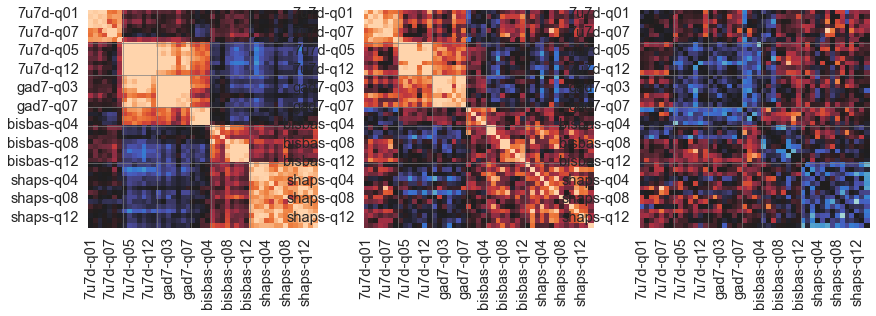

In [13]:
fig, axes = plt.subplots(1,3,figsize=(14,4))

sns.heatmap(Omega_0, center=0, vmin=-0.5, vmax=0.5, cbar=False, ax=axes[0])
sns.heatmap(Omega_1, center=0, vmin=-0.5, vmax=0.5, cbar=False, ax=axes[1])
sns.heatmap(-delta, center=0, vmin=-0.5, vmax=0.5, cbar=False, ax=axes[2])

for ax in axes:
    ax.axhline(7, color='0.5', lw=0.7);  ax.axvline(7, color='0.5', lw=0.7)
    ax.axhline(14, color='0.5', lw=0.7); ax.axvline(14, color='0.5', lw=0.7)
    ax.axhline(21, color='0.5', lw=0.7); ax.axvline(21, color='0.5', lw=0.7)
    ax.axhline(25, color='0.5', lw=0.7); ax.axvline(25, color='0.5', lw=0.7)
    ax.axhline(33, color='0.5', lw=0.7); ax.axvline(33, color='0.5', lw=0.7)

In this section, we're trying to show 